### Visualization from lecture to get an overview

(198, 4096)
(198, 1)


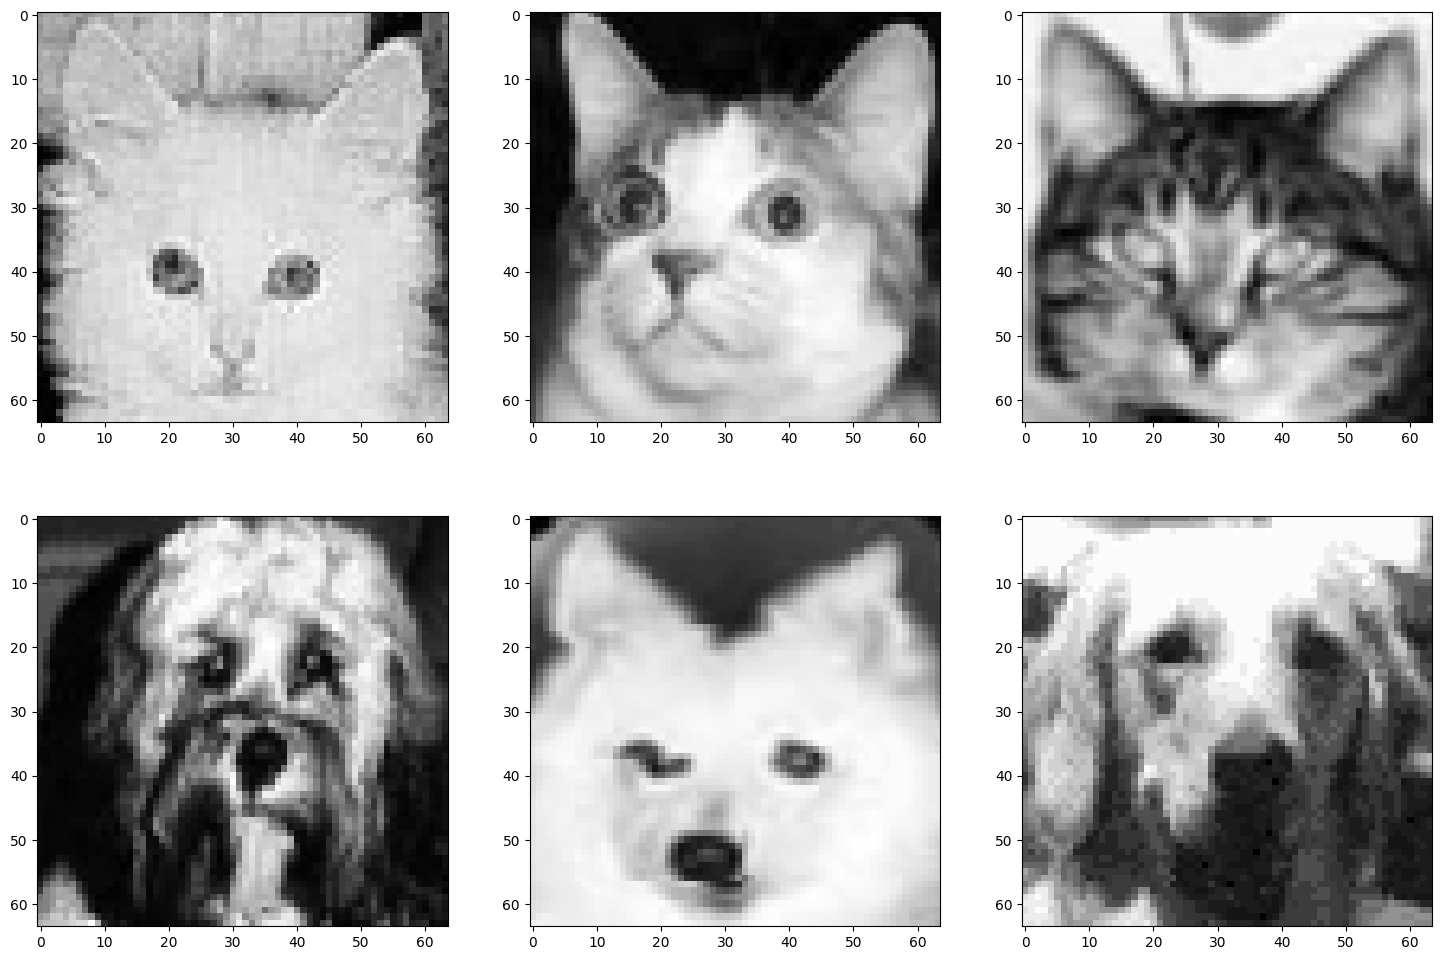

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import trange

CATSnDOGS = np.array(pd.read_csv("CATSnDOGS.csv"))
Labels = np.array(pd.read_csv("Labels.csv"))
print(np.shape(CATSnDOGS))
print(np.shape(Labels))

def rotateM(x):
    return np.transpose(np.apply_along_axis(np.flip, 0, x))

np.random.seed(1000012)
ssc = np.random.choice(np.where(Labels == 0)[0], 3, replace=False)
ssd = np.random.choice(np.where(Labels == 1)[0], 3, replace=False)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for i in range(3):
    axes[0][i].imshow(rotateM(np.reshape(CATSnDOGS[ssc[i], :], (64, 64))), cmap='gray')
    axes[0][i].set_xlabel("")
    axes[0][i].set_ylabel("")
    
for i in range(3):
    axes[1][i].imshow(rotateM(np.reshape(CATSnDOGS[ssd[i], :], (64, 64))), cmap='gray')
    axes[1][i].set_xlabel("")
    axes[1][i].set_ylabel("")

plt.show()

## Class separation

In [2]:
def get_misclassified_indices(clf, features, labels, dataset):
    # Make predictions on the input data
    y_pred = clf.predict(features)
    
    # Find misclassified samples
    misclassified_idx = [i for i in range(len(labels)) if labels[i] != y_pred[i]]
    misclassified = features[misclassified_idx]
    
    # Find indices of misclassified samples in the original dataset
    indices = []
    for i in range(misclassified.shape[0]):
        image = misclassified[i,:]
        idx = np.where((dataset==image).all(axis=1))[0][0]
        indices.append(idx)
    
    return indices

In [3]:
# Classifiers
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)


svm = make_pipeline(
    StandardScaler(),
    SVC()
)

rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(100,))
)

clfs = [lr, svm, rf, mlp]
clfs_name = ['LR', 'SVM', 'RF', 'MLP', 'CNN']

In [4]:
from sklearn.model_selection import cross_val_score
iterations = 100

def clf_scores(data, labels, clfs, clfs_name, iterations, score):
    clf_scores = {}
    for clf, name in zip(clfs, clfs_name):
        score_list = []
        for i in trange(iterations):
            cv_score = cross_val_score(clf, data, labels.ravel(), scoring=score, cv=5)
            mean_score_cv = np.mean(cv_score)
            score_list.append(mean_score_cv)
        mean_score_it = np.mean(score_list)
        clf_scores[name] = mean_score_it
        
    return clf_scores

In [5]:
accuracy = clf_scores(CATSnDOGS, Labels, clfs, clfs_name, iterations, 'accuracy')
recall = clf_scores(CATSnDOGS, Labels, clfs, clfs_name, iterations, 'recall')
precision = clf_scores(CATSnDOGS, Labels, clfs, clfs_name, iterations, 'precision')

## Add convolutional networks score
accuracy['CNN'] = 0.8579
recall['CNN'] = 0.8594
precision['CNN'] = 0.8660

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:32<00:00,  6.92s/it]


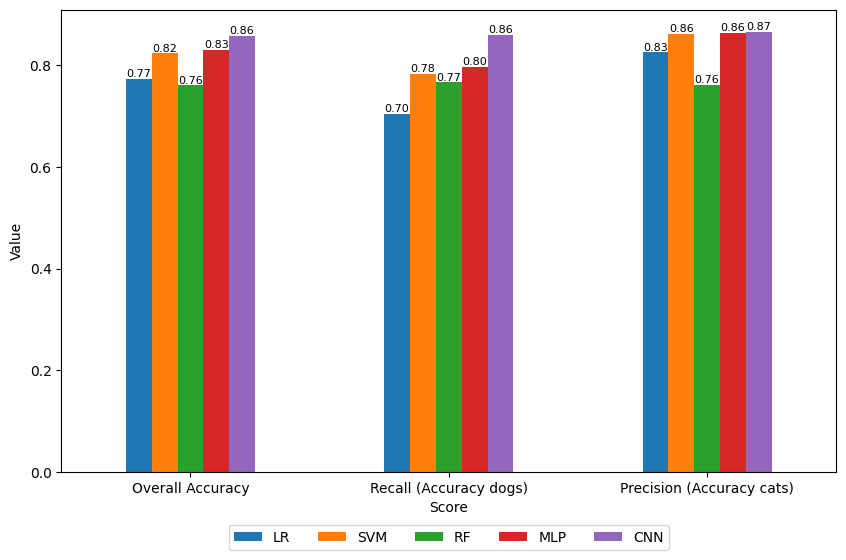

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def barplot(score_values, score_names):
    df = pd.DataFrame(score_values, index=score_names, columns=clfs_name)
    ax = df.plot.bar(rot=0, figsize=(10,6))
    
    
    # Add score names below the bars
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(clfs_name))
    ax.set_xlabel('Score')
    ax.set_ylabel('Value')
    ax.set_xticklabels(score_names)
    
    # Add exact values above the bars
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', fmt='%.2f', fontsize=8)
    
    plt.show()
        
score_values = [accuracy.values(), recall.values(), precision.values()]
score_names = ['Overall Accuracy', 'Recall (Accuracy dogs)', 'Precision (Accuracy cats)']

barplot(score_values, score_names)

### Reflection
Upon analyzing the classifiers tested, it becomes apparent that cats and dogs are distinguishable with relatively high accuracy, as shown by the classifiers' performance, ranging from 76% to 83%. While there may be some overlap between the two categories, the classifiers are still able to accurately differentiate between them. Interestingly, the classifiers seem to find classifying cats a tad easier than dogs, with the exception of the random forest classifier, which performs remarkably well in both categories. Furthermore, a noteworthy observation is that the logistic regression classifier shows significant variance in precision and recall.

#### About the observation on random forest
Random forest classifier can handle both linear and non-linear decision boundaries, as it is a tree-based model that builds multiple decision trees and combines their predictions to make a final decision. This ability to capture non-linear relationships between features may contribute to the random forest classifier's consistent performance across both cat and dog classifications.

#### About the observation on logistic regression
The logistic regression classifier showing significant variance in precision and recall could be due to the fact that logistic regression assumes that the decision boundary between classes is linear. If the decision boundary is not linear, then logistic regression may not be able to accurately model the data, which can lead to differences in precision and recall.

#### Some thoughts based on later findings about feature selection
Random forest classifier's ability to identify important features, such as the forehead, ears, and mouth regions, may explain why it performs equally well in predicting both cats and dogs. These regions can often have distinct characteristics that distinguish one pet from another. However, when the visual appearance of these regions is similar between cats and dogs, it may result in misclassifications for both categories, and therefore, the classifier may fail to predict each class equally.

Logistic regression relies on outlining and silhouette of facial features to identify important visual characteristics that can distinguish between the classes. There may be instances where a cat's facial features resemble those of a dog. Therefore, while logistic regression may perform well in identifying dogs, its performance in identifying cats may be more limited, especially in cases where the cats have similar features to dogs.

In [5]:
def common(counts, threshold):
    most_common = []
    for key, count in counts.items():
        if count > threshold:
            most_common.append(key)
    most_common = sorted(most_common, key=lambda key: counts[key], reverse=True)
    return most_common

In [6]:
from collections import Counter
from sklearn.model_selection import KFold
# Define lists to store the misclassified indices for each classifier
lr_indices_list = []
svm_indices_list = []
rf_indices_list = []
mlp_indices_list = []
all_indices = []

iterations = 500

num_folds = 5
for i in trange(iterations):

    # Split the data into training and testing sets with 5-fold cross validation
    kf = KFold(n_splits=num_folds, shuffle=True)
    for i, (train_idx, test_idx) in enumerate(kf.split(CATSnDOGS)):
        train_features, train_labels = CATSnDOGS[train_idx], Labels.ravel()[train_idx]
        test_features, test_labels = CATSnDOGS[test_idx], Labels.ravel()[test_idx]

        # Train the classifiers using the pipeline
        lr.fit(train_features, train_labels)
        svm.fit(train_features, train_labels)
        rf.fit(train_features, train_labels)
        mlp.fit(train_features, train_labels)

        # Make predictions on the testing data
        lr_pred = lr.predict(test_features)
        svm_pred = svm.predict(test_features)
        rf_pred = rf.predict(test_features)
        mlp_pred = mlp.predict(test_features)

        # Get misclassified indices for each classifier and store them in separate lists
        lr_indices = get_misclassified_indices(lr, test_features, test_labels, CATSnDOGS)
        lr_indices_list += lr_indices
        
        svm_indices = get_misclassified_indices(svm, test_features, test_labels, CATSnDOGS)
        svm_indices_list += svm_indices
        
        rf_indices = get_misclassified_indices(rf, test_features, test_labels, CATSnDOGS)
        rf_indices_list += rf_indices
        
        mlp_indices = get_misclassified_indices(mlp, test_features, test_labels, CATSnDOGS)
        mlp_indices_list += mlp_indices

        indices = lr_indices + svm_indices + rf_indices + mlp_indices
        all_indices += indices


    
    
lr_counts = Counter(lr_indices_list)
svm_counts = Counter(svm_indices_list)
rf_counts = Counter(rf_indices_list)
mlp_counts = Counter(mlp_indices_list) 
    
## For separate classifiers
threshold_sep = iterations*0.2
lr_common = common(lr_counts, threshold_sep)
svm_common = common(svm_counts, threshold_sep)
rf_common = common(rf_counts, threshold_sep)
mlp_common = common(mlp_counts, threshold_sep)

# Find common elements between Logistic Regression and SVM
lr_svm_common = set(lr_common).intersection(set(svm_common))

# Find common elements between Logistic Regression, SVM, and Random Forest
lr_svm_rf_common = set(lr_common).intersection(set(svm_common)).intersection(set(rf_common))

# Find common elements between all arrays
all_common = set(lr_common).intersection(set(svm_common)).intersection(set(rf_common)).intersection(set(mlp_common))

print('Common elements between Logistic Regression and SVM:', lr_svm_common)
print('Common elements between Logistic Regression, SVM, and Random Forest:', lr_svm_rf_common)
print('Common elements between all arrays:', all_common)


## For all classifiers
# If a image was misclassified more than 20% of the time
counts = Counter(all_indices)
nr_clfs = 4
threshold = nr_clfs * iterations * 0.2
most_common = common(counts, threshold)

# Print most common misclassified images
print(f'Most common misclassified images: {most_common}')

  9%|▉         | 47/500 [06:01<57:40,  7.64s/it]  

In [12]:
print(counts.most_common(5))

[(85, 439), (112, 428), (37, 428), (151, 423), (93, 408)]


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mislabel_counts(counts_dic, title):
    
    # Create bar plot
    counts = list(counts_dic.values())
    features = list(counts_dic.keys())
    plt.bar(features, counts)
    plt.xlabel('Images')
    plt.ylabel('Misclassified count')
    plt.title(title)
    plt.show()

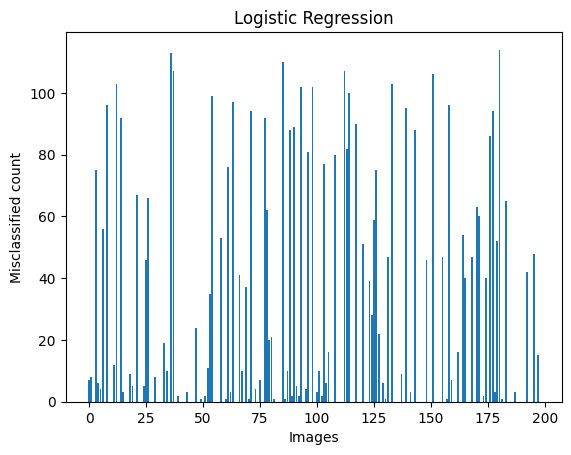

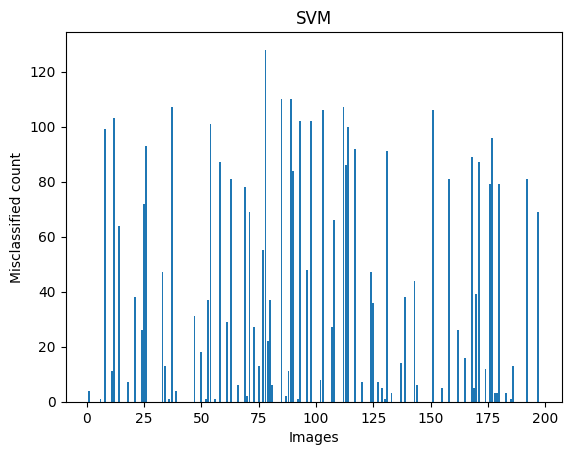

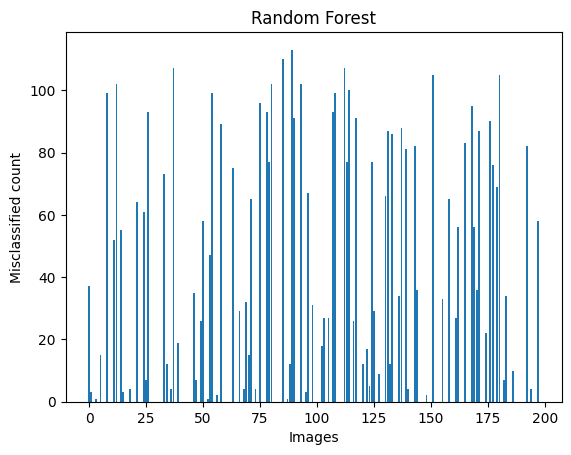

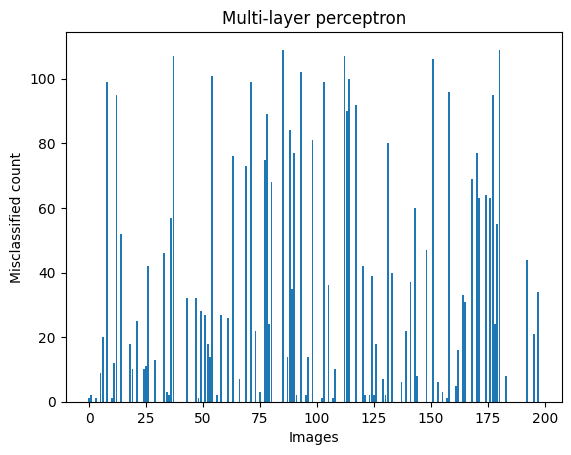

In [15]:
most_common.append(12)
plot_mislabel_counts(lr_counts, 'Logistic Regression')
plot_mislabel_counts(svm_counts, 'SVM')
plot_mislabel_counts(rf_counts, 'Random Forest')
plot_mislabel_counts(mlp_counts, 'Multi-layer perceptron')

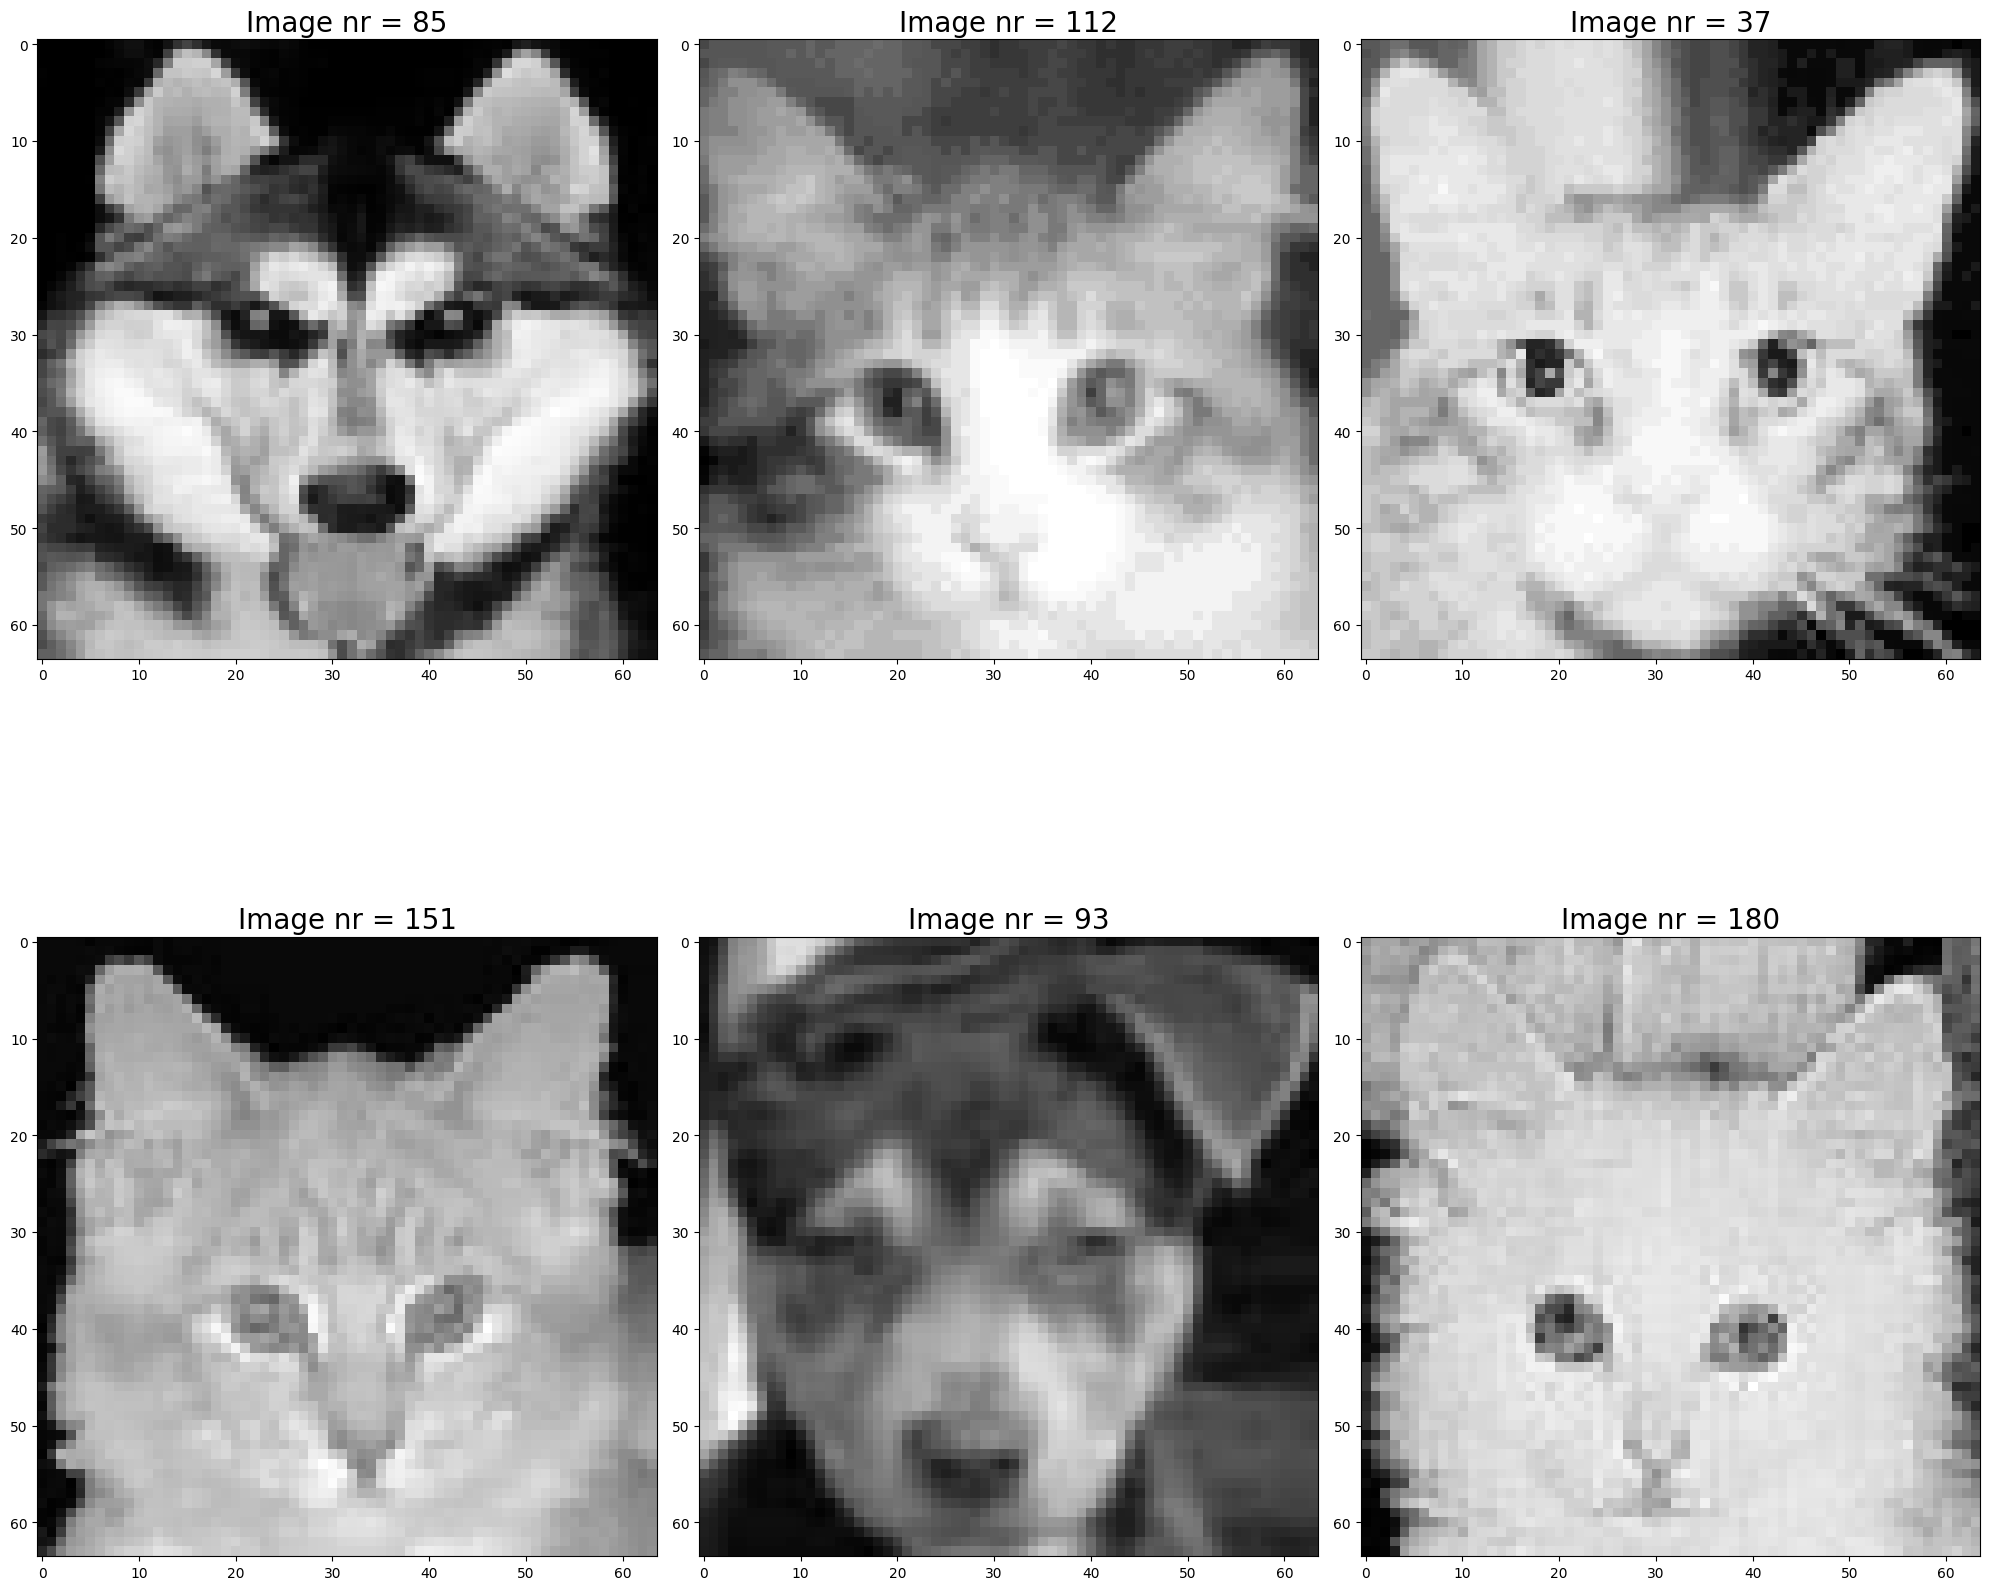

In [16]:
# Show the 6 most misclassified images
rows = 2
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
id = 0
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(rotateM(np.reshape(CATSnDOGS[most_common[id], :], (64, 64))), cmap='gray')
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        axes[i][j].set_title(f'Image nr = {most_common[id]}', fontsize=20)
        id += 1
plt.tight_layout()

### Reflection
Several images of cats and dogs are consistently misclassified by all classifiers, particularly those featuring pets with sharply pointed ears. This is likely due to the similarity in shape between the ears of cats and dogs, making it difficult for the models to differentiate between the two. It could also be due to the positioning of the ears. Additionally, the presence of eyes with little difference in color between pupil and iris may also pose a challenge for accurate classification.

## Feature selection
Identify the most important pixels for classification - are these easy to identify or is there uncertainty in the selection of important features? Compare at least 2 methods for selecting/identifying features. Note, does not need to be the same methods as in 1a. Can you think of a way to improve on the stability of selection/identification?

Can you explain why these pixels are selected/are deemed important?

Do the identified predictive features differ between the classification methods?

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_counts(counts_dic, title):
    
    # Create bar plot
    counts = list(counts_dic.values())
    features = list(counts_dic.keys())
    plt.bar(features, counts, width=20)
    plt.xlabel('Feature index')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

### Feature Selection with Bootstrap Resampling
Bootstrap resampling feature selection is a good way to increase certainty because it involves repeatedly resampling the training set and performing feature selection on each resampled dataset. By doing this, we are able to obtain multiple estimates of the selected features, which can be used to compute the stability of the feature selection. Features that are consistently selected across multiple resampled datasets are more likely to be important than features that are only selected in a few resampled datasets.

By using this approach, we can increase our confidence in the selected features and reduce the uncertainty associated with the feature selection process. Additionally, we can estimate the variability in the feature selection results and obtain a more accurate picture of the important features in the dataset. This can help to avoid overfitting and improve the generalizability of the model. Overall, bootstrap resampling feature selection is a robust and reliable method for selecting important features in a dataset.

Bootstrap resampling with replacement also introduces some level of noise into the feature selection process, which can help to reduce overfitting and improve the generalization of the feature selection model. The following implementation with ShuffleSplit uses replacement

In [70]:
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from collections import Counter
from tqdm import trange
from tqdm import tqdm

def feature_selection_boostrap(data, Labels, nr_iterations):
    bootstrap_size = 0.9
    
    ss = ShuffleSplit(n_splits=nr_iterations, train_size=bootstrap_size)
    
    # Initialize Counter to keep track of feature selection frequencies
    feature_selection_reg = Counter()
    feature_selection_rf = Counter()
    feature_selection_logreg = Counter()
    feature_selection_logreg_elasticnet = Counter()
    
    for train_index, _ in tqdm(ss.split(CATSnDOGS), total=nr_iterations, desc='Bootstrap Resampling'):
        train_features = CATSnDOGS[train_index]
        train_labels = Labels[train_index].ravel()

        # SVM with l1 regularization
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000).fit(train_features, train_labels)
        lsvc_model = SelectFromModel(lsvc, prefit=True)
        selected_indices = lsvc_model.get_support(indices=True)
        feature_selection_reg.update(selected_indices)
        
        # Random forest
        forest = RandomForestClassifier(n_estimators=100).fit(train_features, train_labels)
        importances = forest.feature_importances_
        selected_indices = np.where(importances > 0.001)[0]
        feature_selection_rf.update(selected_indices)
        
        # Logistic Regression
        logreg = LogisticRegression(C=0.1, penalty="l1", solver='liblinear', max_iter=10000).fit(train_features, train_labels)
        logreg_model = SelectFromModel(logreg, prefit=True)
        selected_indices = logreg_model.get_support(indices=True)
        feature_selection_logreg.update(selected_indices)
        
        # Logistic Regression with elasticnet
        logreg2 = LogisticRegression(C=0.1, penalty="elasticnet", solver='saga', l1_ratio=0.8, max_iter=10000).fit(train_features, train_labels)
        logreg_model2 = SelectFromModel(logreg2, prefit=True)
        selected_indices = logreg_model2.get_support(indices=True)
        feature_selection_logreg_elasticnet.update(selected_indices)
        

    return feature_selection_reg, feature_selection_rf, feature_selection_logreg, feature_selection_logreg_elasticnet

In [ ]:
nr_iterations = 100
reg_counts, tree_counts, logreg_counts, logreg_elas_counts = feature_selection_boostrap(CATSnDOGS, Labels, nr_iterations)

Bootstrap Resampling:  98%|███████████████████████████████████████████████████████▊ | 98/100 [1:39:17<01:25, 42.68s/it]

In [ ]:
plot_counts(reg_counts, 'Linear SVC with L1-penalty')
plot_counts(tree_counts, 'Random Forest')
plot_counts(logreg_counts, 'Logistic Regression with L1-penalty')
plot_counts(logreg_elas_counts, 'Logistic Regression with Elasticnet')

In [ ]:
def visualization_selected_features(reg_counts, tree_counts, logreg_counts, logreg_elastic_counts):
    # Only consider features that have been selected x% of the time
    threshold = nr_iterations * 0.1
    most_selected_features_reg = common(reg_counts, threshold)

    threshold = nr_iterations * 0.2
    most_selected_features_tree = common(tree_counts, threshold)

    threshold = nr_iterations * 0.2
    most_selected_features_logreg = common(logreg_counts, threshold)
    
    threshold = nr_iterations * 0.9
    most_selected_features_logreg_elastic = common(logreg_elastic_counts, threshold)


    image = np.zeros((1, len(CATSnDOGS[10, :])))
    image[0, most_selected_features_reg] = 1
    plt.imshow(rotateM(np.reshape(CATSnDOGS[10, :], (64, 64))), cmap='gray')
    plt.imshow(rotateM(np.reshape(image, (64, 64))), cmap='plasma', alpha=0.5)
    plt.title('Selected pixels from SVC with L1-penalty')
    plt.show()

    image = np.zeros((1, len(CATSnDOGS[10, :])))
    image[0, most_selected_features_tree] = 1
    plt.imshow(rotateM(np.reshape(CATSnDOGS[10, :], (64, 64))), cmap='gray')
    plt.imshow(rotateM(np.reshape(image, (64, 64))), cmap='plasma', alpha=0.5)

    plt.title('Selected pixels from Random Forest')
    plt.show()

    image = np.zeros((1, len(CATSnDOGS[10, :])))
    image[0, most_selected_features_logreg] = 1
    plt.imshow(rotateM(np.reshape(CATSnDOGS[10, :], (64, 64))), cmap='gray')
    plt.imshow(rotateM(np.reshape(image, (64, 64))), cmap='plasma', alpha=0.5)
    plt.title('Selected pixels from Logistic regression with L1-penalty')
    plt.show()
    
    image = np.zeros((1, len(CATSnDOGS[10, :])))
    image[0, most_selected_features_logreg_elastic] = 1
    plt.imshow(rotateM(np.reshape(CATSnDOGS[10, :], (64, 64))), cmap='gray')
    plt.imshow(rotateM(np.reshape(image, (64, 64))), cmap='plasma', alpha=0.5)
    plt.title('Selected pixels from Logistic regression with elasticnet')
    plt.show()

In [ ]:
visualization_selected_features(reg_counts, tree_counts, logreg_counts, logreg_elas_counts)

### Impurity heat map

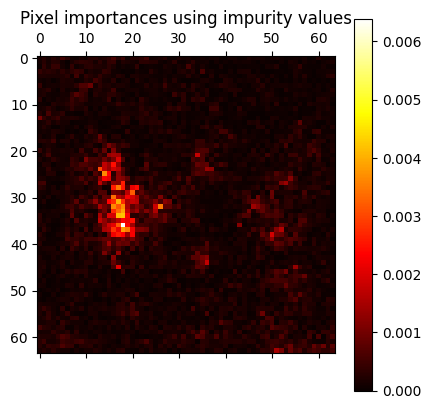

In [31]:
import time
import matplotlib.pyplot as plt

forest = RandomForestClassifier(n_estimators=1000)
forest.fit(CATSnDOGS, Labels.ravel())
img_shape = (64, 64)
importances = forest.feature_importances_

imp_reshaped = importances.reshape(img_shape)
plt.matshow(imp_reshaped, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.show()

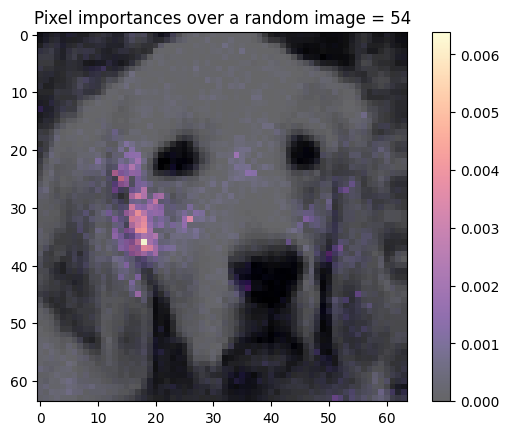

In [69]:
import random
random_image = random.randint(1, len(Labels))

plt.title(f"Pixel importances over a random image = {random_image}")
plt.imshow(rotateM(np.reshape(CATSnDOGS[random_image, :], (64, 64))), cmap='gray')
plt.imshow(imp_reshaped, cmap='magma', alpha=0.75)
plt.colorbar()

### Reflection
Based on the results obtained from the feature selection techniques used in the classification of dogs and cats images, it appears that the regularization-based method tends to prioritize the pixels located at the outer edges of the silhouettes of the animals. On the other hand, the tree-based method assigns more importance to the pixels located on the forehead area between the ears, with some additional pixels in the mouth/chin region.

Determining why certain pixels are more important than others in feature selection can be a challenging task. Moreover, selecting specific pixels with confidence is also difficult. In cases where feature selection is performed on a single or a few instances, the selected features are likely to change, leading to uncertainty in the selected features. To mitigate this, it is recommended to resample the train-test split over several iterations and perform feature selection multiple times to reduce uncertainty. Nevertheless, some pixels are consistently selected by both classifiers, which may suggest their importance. In general, the feature selection methods tend to select different sets of features with less overlap than variation.

#### Improve stability
There are several ways to potentially improve the stability of feature selection. Here are a few:

- Using bootstrap resampling feature selection
- Increase the number of bootstrap samples: By increasing the number of bootstrap samples, we can get a better estimate of the stability of each feature. However, this comes at the cost of increased computational time.

- Perform feature selection in multiple stages: By performing feature selection in multiple stages, we can potentially reduce the impact of noise or instability in the selection process. For example, we could first use a more robust method to select a small set of features, and then use a more sensitive method to further refine the selection.


## Difference between the feature selection methods
The observation that regularization-based method prioritizes the pixels at the outer edges of the silhouettes of the animals while the tree-based method assigns more importance to the pixels located on the forehead area between the ears and mouth/chin region, could be due to the different ways the methods assign importance to the features. Regularization-based methods use penalties to encourage sparse feature selection, and may favor features that have a high correlation with the outcome but are not redundant with other selected features. On the other hand, tree-based methods use decision trees to recursively partition the feature space, and may assign importance to features that lead to informative splits in the tree. However, it is difficult to determine the exact reason why certain pixels are considered more important than others, and it is also challenging to be confident in the selection of specific pixels. Using stability selection, as discussed earlier, could improve the confidence in the selected features. Overall, the observation that the two methods tend to select different sets of features with less overlap than variation suggests that combining the two methods may lead to a more robust feature selection process.

# Task 2

## Classification with spoiled data

In [5]:
def visualize(data, rows, cols, defected_images_index):
    rows = 2
    cols = 3
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
    id = 0
    for i in range(rows):
        for j in range(cols):
            axes[i][j].imshow(rotateM(np.reshape(data[defected_images_index[id], :], (64, 64))), cmap='gray')
            axes[i][j].set_xlabel("")
            axes[i][j].set_ylabel("")
            id += 1
    plt.tight_layout()

In [6]:
import random
def create_dataset_and_visualize(data, labels, missing_level_pics, missing_level_pixels, rows, cols, mode=[]):
    # Findes the index of the pictures to be damaged
    nr_of_images = len(labels)
    defected_images_index = random.sample(range(nr_of_images), int(nr_of_imagesmissing_level_pics))

    if len(mode) > 0:
        bias = mode[0]
        overbias_level = mode[1] 
        underbias_level = mode[2]
        for index in defected_images_index:
            picture = data[index, :]

            for i in range(len(picture)):
                r = np.random.rand()
                if picture[i] >= biasmax(picture):
                    if r < overbias_level:
                        picture[i] = 0

                else:
                    if r < underbias_level:
                        picture[i] = 0

            data[index, :] = picture
    else:

        for index in defected_images_index:
            picture = data[index, :]

            delete_index = random.sample(range(len(picture)), int(len(picture)*missing_level_pixels))

            for i in delete_index:
                picture[i] = 0
            data[index, :] = picture

    visualize(data, rows, cols, defected_images_index)

In [7]:
def remove_pixels(data, defected_images_indices, missing_level_pixels):
    for index in defected_images_indices:
        picture = data[index, :]
        delete_index = random.sample(range(len(picture)), int(len(picture)*missing_level_pixels))
        for i in delete_index:
            picture[i] = -10
        data[index, :] = picture
    return data

In [8]:
from sklearn.impute import KNNImputer
def impute(data):
    nr_imgs = data.shape[0]
    imputer = KNNImputer(missing_values=-10, n_neighbors=8, weights="uniform")
    for i in range(nr_imgs):
        image_temp = np.reshape(data[i, :], (64, 64))
        image = imputer.fit_transform(image_temp)
        data[i, :] = np.ndarray.flatten(image)
               
    return data

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import random
import numpy as np


def prediction_spoiled_data(classifier, name, iterations, data, Labels, level, imputing):
    classifier_list_acc, classifier_list_rec, classifier_list_pre = [], [], []
    folds_list_acc, folds_list_rec, folds_list_pre = [], [], []
    score_dict = {}
    missing_level_imgs, missing_level_pixels = level
    num_folds = 5
    for i in trange(iterations):
        kf = KFold(n_splits=num_folds, shuffle=True)
        for i, (train_idx, test_idx) in enumerate(kf.split(data)):

            train_features, train_labels = data[train_idx], Labels.ravel()[train_idx]
            test_features, test_labels = data[test_idx], Labels.ravel()[test_idx]


            # Making new training data for data where images with missing pixels is removed
            nr_of_images = len(train_labels)
            removing_indices = random.sample(range(nr_of_images), int(nr_of_images*missing_level_imgs))
            removed_pixel_data = remove_pixels(train_features, removing_indices, missing_level_pixels)
            
            
            if imputing is False:
                # Remove images with missing pixels
                train_features = np.delete(train_features, removing_indices, axis=0)
                train_labels = np.delete(train_labels, removing_indices)
            else:
                train_features = impute(train_features)

            # Train the classifiers using the pipeline
            classifier.fit(train_features, train_labels)

            # Make predictions on the testing data and calculate the accuracies
            classifier_pred = classifier.predict(test_features)
            classifier_acc = accuracy_score(test_labels, classifier_pred)
            classifier_rec = recall_score(test_labels, classifier_pred)
            classifier_pre = precision_score(test_labels, classifier_pred)

            folds_list_acc.append(classifier_acc)
            folds_list_rec.append(classifier_rec)
            folds_list_pre.append(classifier_pre)
        classifier_list_acc.append(np.mean(folds_list_acc))
        classifier_list_rec.append(np.mean(folds_list_rec))
        classifier_list_pre.append(np.mean(folds_list_pre))
    
    # Print the test accuracies
    print(name + " Accuracy:", np.mean(classifier_list_acc))
    print(name + " Recall:", np.mean(classifier_list_rec)) 
    print(name + " Precision:", np.mean(classifier_list_pre)) 
    
    score_dict['Accuracy'] = np.mean(classifier_list_acc)
    score_dict['Recall'] = np.mean(classifier_list_rec)
    score_dict['Precision'] = np.mean(classifier_list_pre)
    return score_dict


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def barplot_spoiled(score_values, score_names, title):
    df = pd.DataFrame(score_values, index=score_names, columns=clfs_name)
    ax = df.plot.bar(rot=0, figsize=(10,6))
    
    
    # Add score names below the bars
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(clfs_name))
    ax.set_title(title)
    ax.set_xlabel('Score')
    ax.set_ylabel('Value')
    ax.set_xticklabels(score_names)
    
    # Add exact values above the bars
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', fmt='%.2f')
    
    plt.show()
        



#### Level of missingness

In [11]:
#Procent of defected pictures
level1_procent_pictures = 0.25
level2_procent_pictures = 0.5

#Procent of defected pixels in each picture for random
level1_procent_pixels = 0.3
level2_procent_pixels = 0.6

#Levels
level1 = (level1_procent_pictures, level1_procent_pixels)
level2 = (level2_procent_pictures, level2_procent_pixels)
levels = [level1, level2]

In [12]:
def impute_or_remove(imputing):
    classifiers = {'LR': lr, 'SVM': svm, 'RF': rf, 'MLP': mlp}
    score_names = ['Overall Accuracy', 'Recall (Accuracy dogs)', 'Precision (Accuracy cats)']
    titles = ['Missingness level 1', 'Missingness level 2']
    i = 0
    iterations = 100
    
    for level in levels:
        score_list = []
        acc_list = []
        recall_list = []
        prec_list = []
        for name, clf in classifiers.items():
            score = prediction_spoiled_data(clf, name, iterations, CATSnDOGS, Labels, level, imputing)
            for score_name, score_val in score.items():
                if score_name == 'Accuracy':
                    acc_list.append(score_val)
                elif score_name == 'Recall':
                    recall_list.append(score_val)
                else:
                    prec_list.append(score_val)

        score_list.append(acc_list)
        score_list.append(recall_list)
        score_list.append(prec_list)
        barplot_spoiled(score_list, score_names, titles[i])
        i += 1

### Classification without imputation

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


LR Accuracy: 0.7508427503663987
LR Recall: 0.7157076597590957
LR Precision: 0.7807236342770618


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


SVM Accuracy: 0.7797601823346918
SVM Recall: 0.7709350272868823
SVM Precision: 0.8050428105384629


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.06s/it]


RF Accuracy: 0.7361244675417252
RF Recall: 0.7416520574625416
RF Precision: 0.7497050056552444


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:56<00:00,  5.36s/it]


MLP Accuracy: 0.7768599500093768
MLP Recall: 0.7482773042884986
MLP Precision: 0.8068677773729006


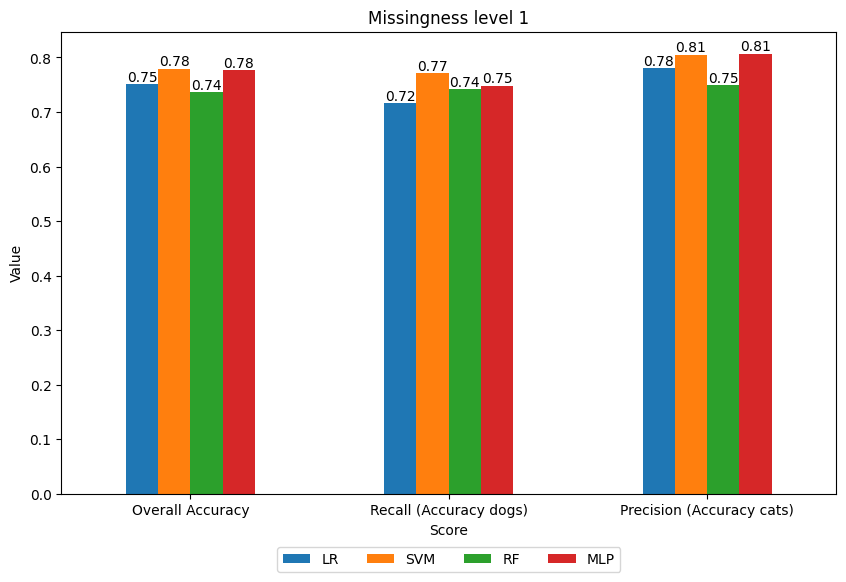

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


LR Accuracy: 0.742000209808715
LR Recall: 0.7102087453990847
LR Precision: 0.774842465644972


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


SVM Accuracy: 0.7517944575073718
SVM Recall: 0.7471043415267649
SVM Precision: 0.7781587773065113


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:27<00:00,  2.07s/it]


RF Accuracy: 0.7274080080864586
RF Recall: 0.7407038348795603
RF Precision: 0.7413232642912617


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:34<00:00,  4.55s/it]


MLP Accuracy: 0.7562378767577317
MLP Recall: 0.7300219338417748
MLP Precision: 0.7854043815152311


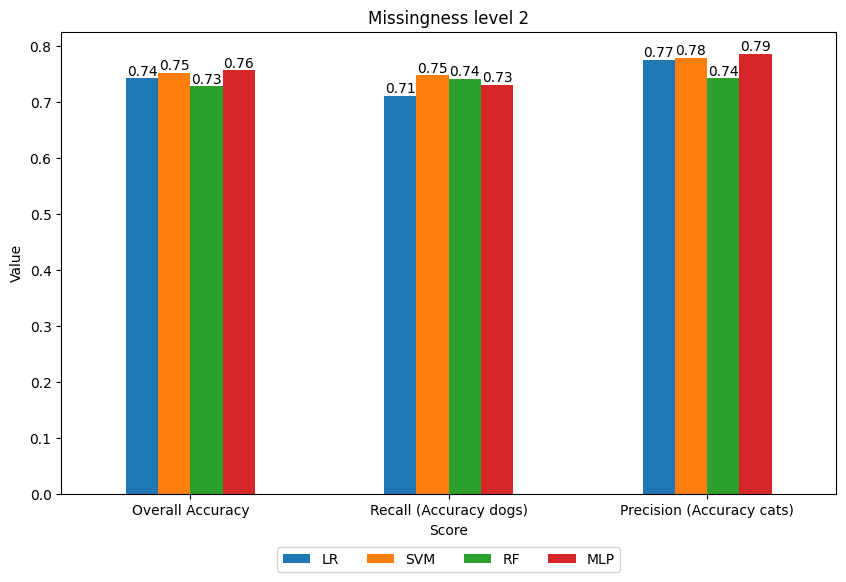

In [13]:
clfs_name = ['LR', 'SVM', 'RF', 'MLP']
impute_or_remove(False)

### Classification with imputation

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:55<00:00,  4.75s/it]


LR Accuracy: 0.7626695665423003
LR Recall: 0.7258016711669079
LR Precision: 0.7962065474796242


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:29<00:00,  4.49s/it]


SVM Accuracy: 0.8000369068879336
SVM Recall: 0.7759020596347831
SVM Precision: 0.8287758663133559


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:48<00:00,  7.09s/it]


RF Accuracy: 0.7519282715663215
RF Recall: 0.7588601123181691
RF Precision: 0.7624443223807559


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:52<00:00, 10.73s/it]


MLP Accuracy: 0.7958778566139552
MLP Recall: 0.7663239472346213
MLP Precision: 0.8246063194835241


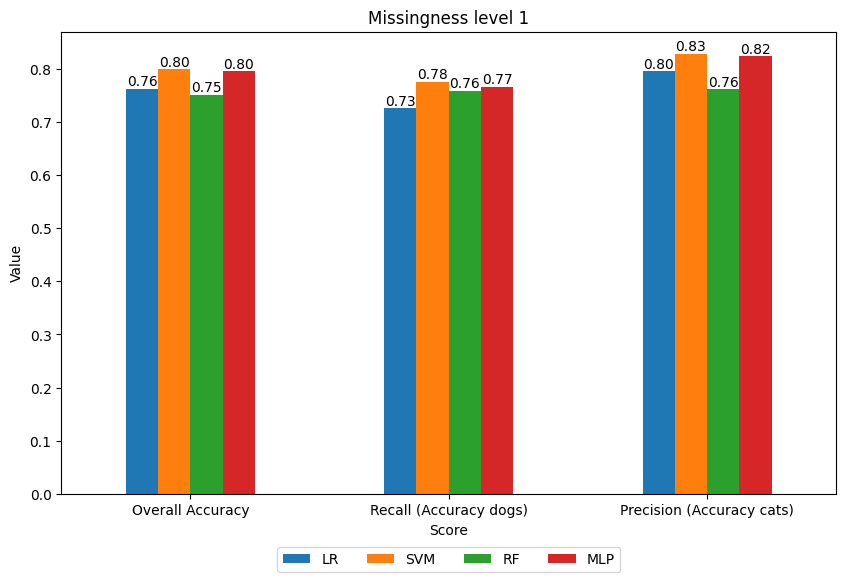

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:39<00:00,  9.39s/it]


LR Accuracy: 0.7584820536434439
LR Recall: 0.7181533293918554
LR Precision: 0.7919103030554467


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:49<00:00,  8.89s/it]


SVM Accuracy: 0.7950318789387457
SVM Recall: 0.7947529533933161
SVM Precision: 0.810831225925074


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [19:10<00:00, 11.50s/it]


RF Accuracy: 0.7560559863489389
RF Recall: 0.7730797230083666
RF Precision: 0.7607453766624463


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [41:23<00:00, 24.84s/it]


MLP Accuracy: 0.8007210126920338
MLP Recall: 0.7835552905032097
MLP Precision: 0.8226431901678031


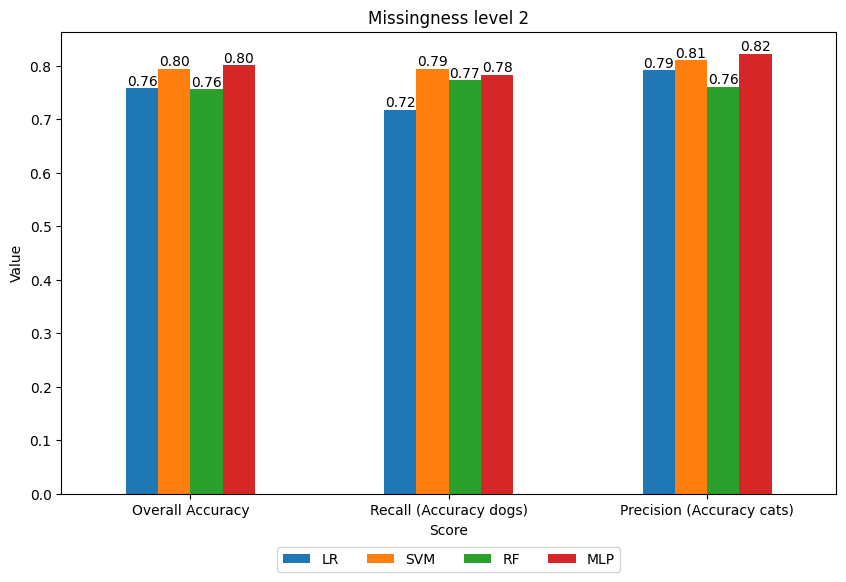

In [29]:
clfs_name = ['LR', 'SVM', 'RF', 'MLP']
impute_or_remove(True)

## Feature selection with spoiled data

In [14]:
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from collections import Counter
from tqdm import trange
from tqdm import tqdm

def feature_selection_boostrap_spoiled(data, Labels, nr_iterations, level, imputing):
    bootstrap_size = 0.9
    missing_level_imgs, missing_level_pixels = level
    ss = ShuffleSplit(n_splits=nr_iterations, train_size=bootstrap_size)
    
    # Initialize Counter to keep track of feature selection frequencies
    feature_selection_reg = Counter()
    feature_selection_rf = Counter()
    feature_selection_logreg = Counter()
    feature_selection_gbc = Counter()
    
    for train_index, _ in tqdm(ss.split(CATSnDOGS), total=nr_iterations, desc='Bootstrap Resampling'):
        train_features = CATSnDOGS[train_index]
        train_labels = Labels[train_index].ravel()
        
        # Making new training data for data where images with missing pixels is removed
        nr_of_images = len(train_labels)
        removing_indices = random.sample(range(nr_of_images), int(nr_of_images*missing_level_imgs))
        removed_pixel_data = remove_pixels(train_features, removing_indices, missing_level_pixels)


        if imputing is False:
            # Remove images with missing pixels
            train_features = np.delete(train_features, removing_indices, axis=0)
            train_labels = np.delete(train_labels, removing_indices)
        else:
            train_features = impute(train_features)
        
        
        # SVM with l1 regularization
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000).fit(train_features, train_labels)
        lsvc_model = SelectFromModel(lsvc, prefit=True)
        selected_indices = lsvc_model.get_support(indices=True)
        feature_selection_reg.update(selected_indices)
        
        # Random forest
        forest = RandomForestClassifier(n_estimators=100).fit(train_features, train_labels)
        importances = forest.feature_importances_
        selected_indices = np.where(importances > 0.001)[0]
        feature_selection_rf.update(selected_indices)
        
        # Logistic Regression
        logreg = LogisticRegression(C=0.1, penalty="l1", solver='liblinear', max_iter=10000).fit(train_features, train_labels)
        logreg_model = SelectFromModel(logreg, prefit=True)
        selected_indices = logreg_model.get_support(indices=True)
        feature_selection_logreg.update(selected_indices)
        

    return feature_selection_reg, feature_selection_rf, feature_selection_logreg

### Level 1 without imputation

In [15]:
nr_iterations = 100

Bootstrap Resampling: 100%|████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]


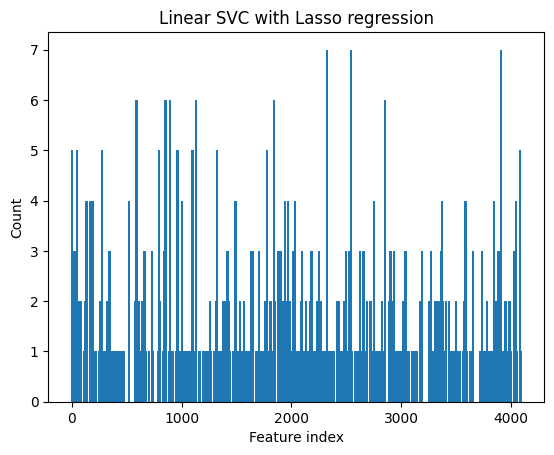

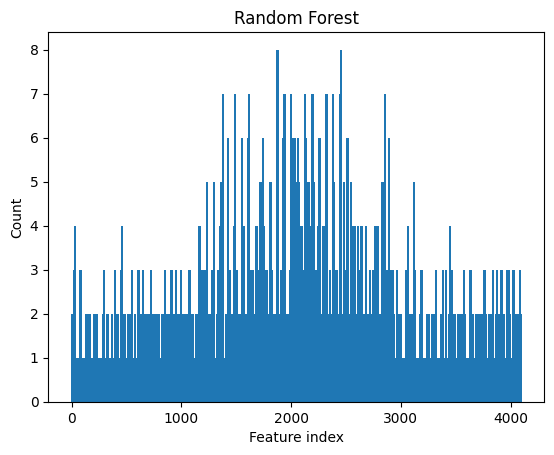

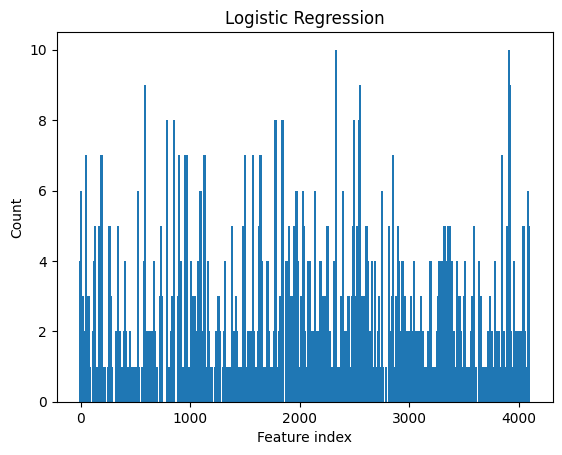

In [150]:
imputing = False

reg_spoil, rf_spoil, logreg_spoil, logreg_elastic_spoil = feature_selection_boostrap_spoiled(CATSnDOGS, Labels, nr_iterations, level1, imputing)
plot_counts(reg_spoil, 'Linear SVC with L1-penalty')
plot_counts(rf_spoil, 'Random Forest')
plot_counts(logreg_spoil, 'Logistic Regression with L1-penalty')
    
visualization_selected_features(reg_spoil, rf_spoil, logreg_spoil)

### Level 1 with imputation

In [ ]:
imputing = True
reg_spoil, rf_spoil, logreg_spoil = feature_selection_boostrap_spoiled(CATSnDOGS, Labels, nr_iterations, level1, imputing)
plot_counts(reg_spoil, 'Linear SVC with L1-penalty')
plot_counts(rf_spoil, 'Random Forest')
plot_counts(logreg_spoil, 'Logistic Regression with L1-penalty')
    
visualization_selected_features(reg_spoil, rf_spoil, logreg_spoil)

### Level 2 without imputation

In [152]:
imputing = False
reg_spoil, rf_spoil, logreg_spoil = feature_selection_boostrap_spoiled(CATSnDOGS, Labels, nr_iterations, level2, imputing)
plot_counts(reg_spoil, 'Linear SVC with L1-penalty')
plot_counts(rf_spoil, 'Random Forest')
plot_counts(logreg_spoil, 'Logistic Regression with L1-penalty')
    
visualization_selected_features(reg_spoil, rf_spoil, logreg_spoil)

### Level 2 with imputation

In [ ]:
imputing = True
reg_spoil, rf_spoil, logreg_spoil = feature_selection_boostrap_spoiled(CATSnDOGS, Labels, nr_iterations, level2, imputing)
plot_counts(reg_spoil, 'Linear SVC with L1-penalty')
plot_counts(rf_spoil, 'Random Forest')
plot_counts(logreg_spoil, 'Logistic Regression with L1-penalty')
    
visualization_selected_features(reg_spoil, rf_spoil, logreg_spoil)